### Load the Aircraft Dataset (mounted to my Google Drive)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FGVC Aircraft Dataset is a collection of images of various aircraft models (good for image classification)

In [ ]:
# Downloading aircraft dataset and extracting for the first time (mounted to Drive)
# !wget http://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz -P /content/drive/MyDrive/fgvc/
# !tar -xvzf /content/drive/MyDrive/fgvc/fgvc-aircraft-2013b.tar.gz -C /content/drive/MyDrive/fgvc/

In [5]:
# Clone meta-dataset repo
!git clone https://github.com/google-research/meta-dataset.git
%cd meta-dataset

fatal: destination path 'meta-dataset' already exists and is not an empty directory.
/content/meta-dataset


In [ ]:
!pip install -r requirements.txt
!pip install tensorflow-datasets

ERROR: Operation cancelled by user


In [ ]:
%%bash
export DATASRC='/content/drive/MyDrive/fgvc/fgvc-aircraft-2013b'
export SPLITS='/content/drive/MyDrive/fgvc/fgvc_aircraft_splits'
export RECORDS='/content/drive/MyDrive/fgvc/fgvc_aircraft_records'

In [ ]:
# Converts data to TFRecord format (used for TensorFlow)

In [ ]:
import os
os.listdir('/content/drive/MyDrive/fgvc/fgvc-aircraft-2013b')


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/fgvc/fgvc-aircraft-2013b'

In [ ]:
!python -m meta_dataset.dataset_conversion.convert_datasets_to_records \
  --dataset=aircraft \
  --aircraft_data_root=$DATASRC \
  --splits_root=$SPLITS \
  --records_root=$RECORDS

In [ ]:
# Define the path to the file
file_path = '/content/meta-dataset/meta-dataset/meta_dataset/dataset_conversion/dataset_to_records.py'

# Read the file
with open(file_path, 'r') as file:
    code = file.readlines()

# Modify the code where 'img.crop(bbox)' is used
for i, line in enumerate(code):
    # Check if the line contains img.crop(bbox)
    if 'img.crop(bbox)' in line:
        # Ensure bbox is a list before cropping by inserting the line above
        # Insert the line to convert bbox to a list
        code.insert(i, "    bbox = list(bbox)  # Ensure bbox is a list\n")
        break  # Exit the loop after making the change

# Write the modified code back to the file
with open(file_path, 'w') as file:
    file.writelines(code)

print("File modified successfully!")


In [ ]:
import subprocess

# Change to the directory where meta-dataset is cloned
os.chdir('/content/meta-dataset/meta-dataset')

# Define the environment variables for the dataset
DATASRC = '/content/drive/MyDrive/fgvc/fgvc-aircraft-2013b'
SPLITS = '/content/drive/MyDrive/fgvc/fgvc_aircraft_splits'
RECORDS = '/content/drive/MyDrive/fgvc/fgvc_aircraft_records'

# Define the command as a list of arguments
command = [
    'python', '-m', 'meta_dataset.dataset_conversion.convert_datasets_to_records',
    '--dataset=aircraft',
    '--aircraft_data_root=' + DATASRC,
    '--splits_root=' + SPLITS,
    '--records_root=' + RECORDS
]

# Run the command and capture the output and error
result = subprocess.run(command, capture_output=True, text=True)

# Print the standard output (stdout) and standard error (stderr)
print("Standard Output:")
print(result.stdout)

print("\nStandard Error (if any):")
print(result.stderr)


### Trying different models
- PCA is an option for image classification

In [ ]:
%cd /content/drive/MyDrive/fgvc/fgvc-aircraft-2013b/data/

/content/drive/MyDrive/fgvc/fgvc-aircraft-2013b/data


In [ ]:
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Step 1: Define Paths to the Aircraft Dataset
train_data_path = '/content/drive/MyDrive/fgvc/fgvc-aircraft-2013b/data/train'  # Update this to your path
val_data_path = '/content/drive/MyDrive/fgvc/fgvc-aircraft-2013b/data/val'      # Update this to your path

# Step 2: Create ImageDataGenerators to Load Images and Labels (No Rescaling needed)
datagen = ImageDataGenerator(rescale=1./255)  # Scale pixel values to [0,1] range

# Step 3: Create ImageDataGenerators for Train and Validation Data
train_data = datagen.flow_from_directory(train_data_path, target_size=(64, 64), batch_size=32, class_mode='categorical')
val_data = datagen.flow_from_directory(val_data_path, target_size=(64, 64), batch_size=32, class_mode='categorical')

# Step 4: Flatten the images to 1D feature vectors
def flatten_images(data_generator):
    features = []
    labels = []

    for batch in data_generator:
        images = batch[0]  # The images are in the first part of the batch
        labels_batch = batch[1]  # The labels are in the second part of the batch

        # Flatten each image (shape [64, 64, 3] -> [12288]) to create 1D feature vector
        flattened_images = images.reshape(images.shape[0], -1)  # Reshape to (batch_size, 64*64*3)

        features.extend(flattened_images)
        labels.extend(labels_batch)

        if len(features) >= len(data_generator.filenames):  # Stop after processing all images
            break

    return np.array(features), np.array(labels)

# Step 5: Extract Features and Labels from Train and Validation Data
train_features, train_labels = flatten_images(train_data)
val_features, val_labels = flatten_images(val_data)

# Step 6: Apply PCA for Dimensionality Reduction (Reduce to 50 Components)
pca = PCA(n_components=50)  # Reduce the features to 50 principal components
train_features_pca = pca.fit_transform(train_features)
val_features_pca = pca.transform(val_features)  # Apply the same PCA transformation to validation set

# Step 7: Standardize the Features (Important for Logistic Regression)
scaler = StandardScaler()
train_features_pca = scaler.fit_transform(train_features_pca)
val_features_pca = scaler.transform(val_features_pca)  # Apply the same scaling to validation set

# Step 8: Train Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000, multi_class='ovr', solver='lbfgs')  # 'ovr' for One-vs-Rest strategy
log_reg.fit(train_features_pca, train_labels)

# Step 9: Make Predictions and Evaluate the Model
val_predictions = log_reg.predict(val_features_pca)

# Step 10: Evaluate the Accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f'Logistic Regression Accuracy on Validation Set: {accuracy:.4f}')


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/fgvc/fgvc-aircraft-2013b/data/train'

### DTD (Describable Textures Dataset)

In [ ]:
!pip install -r requirements.txt
!pip install tensorflow-datasets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# Download the DTD dataset
!wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz

--2024-12-02 21:19:02--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz [following]
--2024-12-02 21:19:03--  https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/octet-stream]
Saving to: ‘dtd-r1.0.1.tar.gz.1’

dtd-r1.0.1.tar.gz.1  34%[=====>              ] 206.98M  24.3MB/s    eta 18s    ^C


In [ ]:
# Set the directory in Google Drive where you want to store the DTD dataset
DATASRC = '/content/drive/MyDrive/dtd'  # Google Drive path

# Create the target directory in Google Drive
!mkdir -p $DATASRC

# Download the DTD dataset into Google Drive
!wget -P $DATASRC https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz

# Extract the tar file in the specified directory on Google Drive
!tar -xvzf $DATASRC/dtd-r1.0.1.tar.gz -C $DATASRC


--2024-12-02 21:28:04--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz [following]
--2024-12-02 21:28:04--  https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/dtd/dtd-r1.0.1.tar.gz.1’

dtd-r1.0.1.tar.gz.1  15%[==>                 ]  90.58M  21.7MB/s    eta 31s    ^C
dtd/
dtd/labels/
dtd/labels/test2.txt
dtd/labels/train2.txt
dtd/labels/test7.txt
dtd/labels/train3.txt
dtd/labels/train8.txt
dtd/labels/val

In [3]:
# List the files in the records directory to confirm
!ls /content/drive/MyDrive/dtd/dtd


images	imdb  labels  records


In [2]:
# Dependencies
import subprocess
import json
import numpy as np
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [6]:
# Step 2: Convert the dataset to TFRecords
command = [
    "python", "-m", "meta_dataset.dataset_conversion.convert_datasets_to_records",
    "--dataset=dtd",
    "--dtd_data_root=/content/drive/MyDrive/dtd/dtd",
    "--records_root=/content/drive/MyDrive/dtd/dtd/records"
]
result = subprocess.run(command, capture_output=True, text=True)
print(result.stdout)
print(result.stderr)



2024-12-10 00:40:52.359021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 00:40:52.421636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 00:40:52.434055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 00:40:54.147560: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1733791255.652319   24137 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/

In [7]:
# Step 3: Load dataset specification
spec_path = "/content/drive/MyDrive/dtd/dtd/records/dtd/dataset_spec.json"
with open(spec_path, "r") as f:
    dataset_spec = json.load(f)

print("Loaded dataset specification:", dataset_spec)

Loaded dataset specification: {'name': 'dtd', 'classes_per_split': {'TRAIN': 33, 'VALID': 7, 'TEST': 7}, 'images_per_class': {'0': 120, '1': 120, '2': 120, '3': 120, '4': 120, '5': 120, '6': 120, '7': 120, '8': 120, '9': 120, '10': 120, '11': 120, '12': 120, '13': 120, '14': 120, '15': 120, '16': 120, '17': 120, '18': 120, '19': 120, '20': 120, '21': 120, '22': 120, '23': 120, '24': 120, '25': 120, '26': 120, '27': 120, '28': 120, '29': 120, '30': 120, '31': 120, '32': 120, '33': 120, '34': 120, '35': 120, '36': 120, '37': 120, '38': 120, '39': 120, '40': 120, '41': 120, '42': 120, '43': 120, '44': 120, '45': 120, '46': 120}, 'class_names': {'0': 'chequered', '1': 'braided', '2': 'interlaced', '3': 'matted', '4': 'honeycombed', '5': 'marbled', '6': 'veined', '7': 'frilly', '8': 'zigzagged', '9': 'cobwebbed', '10': 'pitted', '11': 'waffled', '12': 'fibrous', '13': 'flecked', '14': 'grooved', '15': 'potholed', '16': 'blotchy', '17': 'stained', '18': 'crystalline', '19': 'dotted', '20': '

In [8]:
def parse_tfrecords(record_dir, image_size=(128, 128)):
    """
    Parse TFRecords into images and labels.
    Args:
        record_dir: Directory containing TFRecords.
        image_size: Tuple of (width, height) to resize images.
    Returns:
        Tuple of NumPy arrays (images, labels).
    """
    def parse_example(example_proto):
        # Define feature description based on the inspected TFRecord structure
        feature_description = {
            "image": tf.io.FixedLenFeature([], tf.string),  # Encoded image
            "label": tf.io.FixedLenFeature([], tf.int64),   # Class label
        }
        example = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.image.decode_jpeg(example["image"], channels=3)  # Decode JPEG
        image = tf.image.resize(image, image_size) / 255.0  # Resize and normalize
        label = example["label"]  # Class label
        return image, label

    # Create a dataset from TFRecords
    tfrecord_files = tf.io.gfile.glob(f"{record_dir}/*.tfrecords")
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files)
    parsed_dataset = raw_dataset.map(parse_example)

    # Convert to NumPy arrays
    images, labels = [], []
    for image, label in parsed_dataset:
        images.append(image.numpy().flatten())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
record_dir = "/content/drive/MyDrive/dtd/dtd/records/dtd"
images, labels = parse_tfrecords(record_dir)

# Create the dataset dictionary
vgg_dataset = {
    "data": images,
    "labels": labels,
    "classes": np.unique(labels)
}
print("Dataset loaded:", vgg_dataset["data"].shape, vgg_dataset["labels"].shape)


Dataset loaded: (5640, 49152) (5640,)


# Logistic Regression

In [10]:
# Extract data and labels
X_data = vgg_dataset["data"]  # Shape: (num_samples, flattened_features)
Y_data = vgg_dataset["labels"]

# Subsample for faster training (adjust fraction as needed)
from sklearn.model_selection import train_test_split

X_train, _, Y_train, _ = train_test_split(
    X_data, Y_data, test_size=0.8, random_state=42
)
print(f"Training set shape: {X_train.shape}, {Y_train.shape}")

Training set shape: (1128, 49152), (1128,)


In [11]:
def create_task(dataset, num_classes, num_train_samples, num_test_samples):
    """
    Create a task by sampling `num_classes` and splitting into train/test sets.
    """
    selected_classes = np.random.choice(dataset["classes"], size=num_classes, replace=False)
    X_train, Y_train, X_test, Y_test = [], [], [], []

    for cls in selected_classes:
        # Filter data and labels for the current class
        class_indices = np.where(dataset["labels"] == cls)[0]
        class_data = dataset["data"][class_indices]
        class_labels = dataset["labels"][class_indices]

        # Ensure there are enough samples
        if len(class_data) < num_train_samples + num_test_samples:
            raise ValueError(f"Class {cls} has insufficient samples.")

        # Shuffle and split
        indices = np.random.permutation(len(class_data))
        train_indices = indices[:num_train_samples]
        test_indices = indices[num_train_samples:num_train_samples + num_test_samples]

        X_train.extend(class_data[train_indices])
        Y_train.extend(class_labels[train_indices])
        X_test.extend(class_data[test_indices])
        Y_test.extend(class_labels[test_indices])

    return {
        "X_train": np.array(X_train),
        "Y_train": np.array(Y_train),
        "X_test": np.array(X_test),
        "Y_test": np.array(Y_test),
        "task_name": f"{num_classes}-way Classification Task"
    }


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
import time
import numpy as np

def tune_logistic_regressionflower(X_train, Y_train, subsample_fraction=0.2):
    """
    Perform hyperparameter tuning for Logistic Regression using GridSearchCV.

    Args:
        X_train (np.ndarray): Training features.
        Y_train (np.ndarray): Training labels.
        subsample_fraction (float): Fraction of the dataset to use for tuning.

    Returns:
        LogisticRegression: Tuned logistic regression model.
    """
    # Reshape the data (flatten the images)
    X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten from (28, 28, 1) to (784,)
    print(f"Flattened X_train shape: {X_train.shape}")

    # Subsample the training data
    if subsample_fraction < 1.0:
        X_train, _, Y_train, _ = train_test_split(
            X_train, Y_train, test_size=(1 - subsample_fraction), random_state=42
        )
        print(f"Subsampled X shape: {X_train.shape}, Subsampled Y shape: {Y_train.shape}")

    # Define parameter grid
    param_grid = {'C': [0.01, 0.1, 1.0, 10.0, 100.0]}  # Regularization strength

    # Tune Logistic Regression
    grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, solver='saga'),
    param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
    cv=StratifiedKFold(n_splits=3),
    scoring='accuracy'
    )
    grid_search.fit(X_train, Y_train)

    # Output the best parameters
    print(f"Best parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

In [13]:
def evaluate_with_chollet(model, dataset, num_tasks, num_classes, num_train_samples, num_test_samples, lambda_factor=0.1):
    """
    Evaluate a model using Chollet's measure of intelligence.
    """
    task_metrics = []

    for _ in range(num_tasks):
        task = create_task(dataset, num_classes, num_train_samples, num_test_samples)
        X_train, Y_train = task["X_train"], task["Y_train"]
        X_test, Y_test = task["X_test"], task["Y_test"]

        # Train the model
        start_time = time.time()
        model.fit(X_train, Y_train)
        training_time = time.time() - start_time

        # Evaluate accuracy
        accuracy = model.score(X_test, Y_test)

        # Record task metrics
        task_metrics.append({"utility": accuracy, "cost": training_time})
        print(f"Task: {task['task_name']} | Accuracy: {accuracy:.2f}, Cost: {training_time:.2f}s")

    # Compute Chollet's intelligence score
    total_score = sum(metric["utility"] - lambda_factor * metric["cost"] for metric in task_metrics)
    return total_score / len(task_metrics), task_metrics


In [14]:
from sklearn.utils import resample

def balance_classes(X, Y):
    unique_classes = np.unique(Y)
    balanced_X, balanced_Y = [], []

    for cls in unique_classes:
        cls_indices = np.where(Y == cls)[0]
        cls_X = X[cls_indices]
        cls_Y = Y[cls_indices]

        if len(cls_indices) < 10:  # Minimum desired samples per class
            cls_X, cls_Y = resample(cls_X, cls_Y, replace=True, n_samples=10, random_state=42)

        balanced_X.append(cls_X)
        balanced_Y.append(cls_Y)

    return np.vstack(balanced_X), np.hstack(balanced_Y)

X_balanced, Y_balanced = balance_classes(X_train, Y_train)
print(f"Balanced dataset shape: {X_balanced.shape}, {Y_balanced.shape}")

Balanced dataset shape: (1128, 49152), (1128,)


### Hyperparameter Optimization

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Step 1: Balance and reduce dimensionality
X_balanced, Y_balanced = balance_classes(X_train, Y_train)
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X_balanced)

# Step 2: Oversample the dataset
smote = SMOTE(random_state=42)
X_oversampled, Y_oversampled = smote.fit_resample(X_reduced, Y_balanced)

# Step 3: Subsample the dataset (optional, for speed)
X_subsampled, _, Y_subsampled, _ = train_test_split(
    X_oversampled, Y_oversampled, test_size=0.7, random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subsampled)

# Adjust class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_subsampled), y=Y_subsampled)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(Y_subsampled), class_weights)}

# Define grid search
grid_search = GridSearchCV(
    LogisticRegression(max_iter=5000, solver='saga', class_weight=class_weight_dict),
    param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
    cv=StratifiedKFold(n_splits=2),
    scoring='accuracy',
    verbose=2
)

# Fit the model
grid_search.fit(X_scaled, Y_subsampled)

# Output best parameters
print(f"Best parameters: {grid_search.best_params_}")

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END ............................................C=0.001; total time=   0.2s
[CV] END ............................................C=0.001; total time=   0.1s
[CV] END .............................................C=0.01; total time=   0.2s
[CV] END .............................................C=0.01; total time=   0.2s
[CV] END ..............................................C=0.1; total time=   0.7s
[CV] END ..............................................C=0.1; total time=   0.7s
[CV] END ..............................................C=1.0; total time=   1.4s
[CV] END ..............................................C=1.0; total time=   2.9s
[CV] END .............................................C=10.0; total time=   4.6s
[CV] END .............................................C=10.0; total time=   4.8s
[CV] END ............................................C=100.0; total time=   7.4s
[CV] END ........................................

In [16]:
score, task_metrics = evaluate_with_chollet(
    grid_search.best_estimator_,
    vgg_dataset,  # Original dataset
    num_tasks=5,
    num_classes=5,
    num_train_samples=10,
    num_test_samples=20
)
print(f"Chollet's Intelligence Score: {score:.2f}")

Task: 5-way Classification Task | Accuracy: 0.19, Cost: 199.46s
Task: 5-way Classification Task | Accuracy: 0.20, Cost: 144.47s
Task: 5-way Classification Task | Accuracy: 0.28, Cost: 192.93s
Task: 5-way Classification Task | Accuracy: 0.27, Cost: 164.39s
Task: 5-way Classification Task | Accuracy: 0.19, Cost: 166.09s
Chollet's Intelligence Score: -17.12


In [17]:
import pandas as pd

In [24]:
# Compile metrics for all datasets (Flower, Omniglot, DTD)

# Omniglot Log Reg below
# utility      cost  adjusted_score  task
# 0  0.600000  0.043191        0.595681     1
# 1  0.733333  0.034978        0.729835     2
# 2  0.626667  0.036981        0.622969     3
# 3  0.706667  0.033661        0.703301     4
# 4  0.653333  0.112594        0.642074     5

# Flower Log Reg below
#    utility       cost  adjusted_score  task
# 0     0.67  85.291406       -7.859141     1
# 1     0.47  92.235859       -8.753586     2
# 2     0.77  83.257453       -7.555745     3
# 3     0.62  84.535685       -7.833569     4
# 4     0.74  91.419474       -8.401947     5

omniglot_lr_data = {
    'utility': [0.600000, 0.733333, 0.626667, 0.706667, 0.653333],
    'cost': [0.043191, 0.034978, 0.036981, 0.033661, 0.112594],
    'adjusted_score': [0.595681, 0.729835, 0.622969, 0.703301, 0.642074],
    'task': [1, 2, 3, 4, 5]
}

# Convert the data into a DataFrame
df_omni = pd.DataFrame(omniglot_lr_data)
df_omni['dataset'] = 'Omniglot'

flower_data = {
    'utility': [0.67, 0.47, 0.77, 0.62, 0.74],
    'cost': [85.291406, 92.235859, 83.257453, 84.535685, 91.419474],
    'adjusted_score': [-7.859141, -8.753586, -7.555745, -7.833569, -8.401947],
    'task': [1, 2, 3, 4, 5]
}

# Convert Flower dataset into a DataFrame and add 'dataset' column
df_flower = pd.DataFrame(flower_data)
df_flower['dataset'] = 'Flower'

df_combined = pd.concat([df_flower, df_omni], ignore_index=True)

data = pd.DataFrame(task_metrics)
data['adjusted_score'] = data['utility'] - 0.1 * data['cost']
data['task'] = range(1, len(task_metrics) + 1)  # Add task numbers
data['dataset'] = 'DTD'
df_all_log_reg = pd.concat([data, df_combined], ignore_index=True)
print(df_all_log_reg)

     utility        cost  adjusted_score  task   dataset
0   0.190000  199.461772      -19.756177     1       DTD
1   0.200000  144.466177      -14.246618     2       DTD
2   0.280000  192.934338      -19.013434     3       DTD
3   0.270000  164.387750      -16.168775     4       DTD
4   0.190000  166.087986      -16.418799     5       DTD
5   0.670000   85.291406       -7.859141     1    Flower
6   0.470000   92.235859       -8.753586     2    Flower
7   0.770000   83.257453       -7.555745     3    Flower
8   0.620000   84.535685       -7.833569     4    Flower
9   0.740000   91.419474       -8.401947     5    Flower
10  0.600000    0.043191        0.595681     1  Omniglot
11  0.733333    0.034978        0.729835     2  Omniglot
12  0.626667    0.036981        0.622969     3  Omniglot
13  0.706667    0.033661        0.703301     4  Omniglot
14  0.653333    0.112594        0.642074     5  Omniglot


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_task_metrics(task_metrics, lambda_factor=0.1):
    """
    Visualize the relationship between utility, cost, and adjusted score across tasks.

    Args:
        task_metrics (list): List of dictionaries with "utility" and "cost" for each task.
        lambda_factor (float): Lambda factor used in Chollet's measure.
    """

    # Plot adjusted score vs cost
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='cost',
        y='adjusted_score',
        hue='dataset',
        data=df_all_log_reg,
        palette='viridis',
        sizes=(100, 500),
        legend='full'
    )
    plt.title(f"Adjusted Score vs Cost Across Tasks (λ={lambda_factor}) for Logistic Regression", fontsize=16)
    plt.xlabel("Cost (Training Time in Seconds)")
    plt.ylabel("Adjusted Score")
    plt.legend(title="Dataset", loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

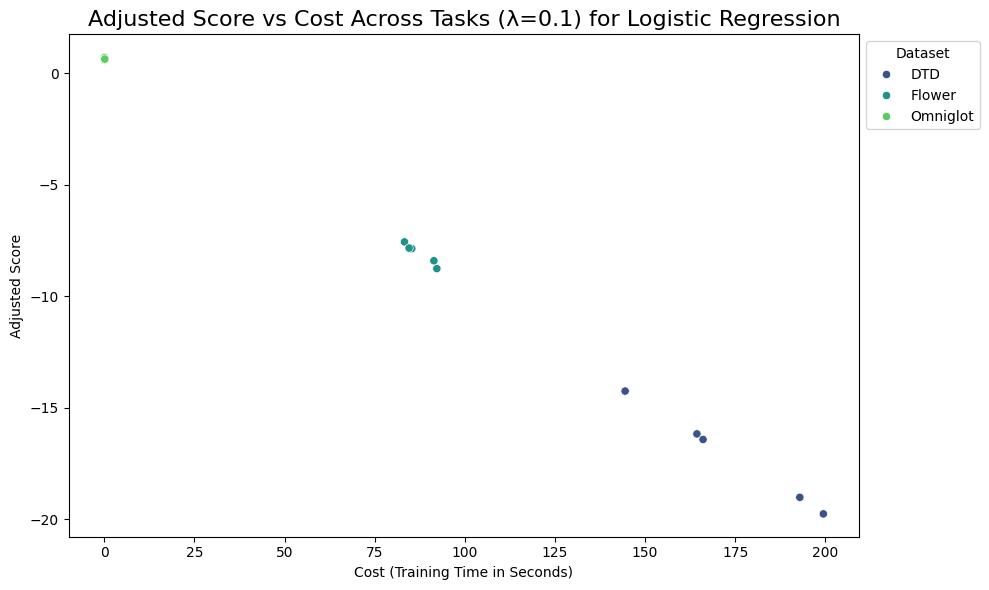

In [26]:
plot_task_metrics(task_metrics, lambda_factor=0.1)

In [31]:
# Stats
# General descriptive stats grouped by dataset
grouped_by_dataset = df_all_log_reg.groupby('dataset').describe()
# print(grouped_by_dataset)
adjusted_score_summary = grouped_by_dataset['adjusted_score']

# Print the summary for 'adjusted_score'
print(adjusted_score_summary)


          count       mean       std        min        25%        50%  \
dataset                                                                 
DTD         5.0 -17.120760  2.246517 -19.756177 -19.013434 -16.418799   
Flower      5.0  -8.080798  0.485210  -8.753586  -8.401947  -7.859141   
Omniglot    5.0   0.658772  0.056067   0.595681   0.622969   0.642074   

                75%        max  
dataset                         
DTD      -16.168775 -14.246618  
Flower    -7.833569  -7.555745  
Omniglot   0.703301   0.729835  


In [59]:
task_error_analysis = df_all_log_reg.groupby('task')['adjusted_score'].describe()
print(task_error_analysis)

      count      mean        std        min        25%       50%       75%  \
task                                                                         
1       3.0 -9.006546  10.224331 -19.756177 -13.807659 -7.859141 -3.631730   
2       3.0 -7.423456   7.576310 -14.246618 -11.500102 -8.753586 -4.011876   
3       3.0 -8.648737   9.863724 -19.013434 -13.284589 -7.555745 -3.466388   
4       3.0 -7.766348   8.436239 -16.168775 -12.001172 -7.833569 -3.565134   
5       3.0 -8.059557   8.535588 -16.418799 -12.410373 -8.401947 -3.879937   

           max  
task            
1     0.595681  
2     0.729835  
3     0.622969  
4     0.703301  
5     0.642074  


### Random Forest

In [32]:
# Parse TFRecords to load dataset
images, labels = parse_tfrecords(record_dir, image_size=(128, 128))

# Subsample for speed
X_subsampled, Y_subsampled = images[:1000], labels[:1000]  # Adjust size for faster tuning

# Flatten the data for Random Forest
X_flattened = X_subsampled.reshape(X_subsampled.shape[0], -1)
print(f"Flattened X shape: {X_flattened.shape}, Y shape: {Y_subsampled.shape}")


Flattened X shape: (1000, 49152), Y shape: (1000,)


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def tune_random_forest(X_train, Y_train, subsample_fraction=0.2):
    """
    Tune a Random Forest model using GridSearchCV.
    """
    # Subsample the training data
    if subsample_fraction < 1.0:
        X_train, _, Y_train, _ = train_test_split(
            X_train, Y_train, test_size=(1 - subsample_fraction), random_state=42
        )
        print(f"Subsampled X shape: {X_train.shape}, Subsampled Y shape: {Y_train.shape}")

    # Parameter grid for Random Forest
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [10, None],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
    }

    # GridSearchCV setup
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=3,  # Cross-validation
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X_train, Y_train)
    print(f"Best parameters: {grid_search.best_params_}")
    return grid_search.best_estimator_


In [34]:
def evaluate_with_chollet_rf(model, dataset, num_tasks=5, num_classes=5, num_train_samples=10, num_test_samples=20):
    """
    Evaluate Chollet's measure for a Random Forest model.
    """
    def create_task(dataset, num_classes, num_train_samples, num_test_samples):
        selected_classes = np.random.choice(dataset["classes"], size=num_classes, replace=False)
        X_train, Y_train, X_test, Y_test = [], [], [], []

        for cls in selected_classes:
            class_indices = np.where(dataset["labels"] == cls)[0]
            sampled_indices = np.random.choice(class_indices, num_train_samples + num_test_samples, replace=False)
            X_train.extend(dataset["data"][sampled_indices[:num_train_samples]])
            Y_train.extend([cls] * num_train_samples)
            X_test.extend(dataset["data"][sampled_indices[num_train_samples:]])
            Y_test.extend([cls] * num_test_samples)

        return {
            "X_train": np.array(X_train).reshape(len(X_train), -1),  # Flatten for RF
            "Y_train": np.array(Y_train),
            "X_test": np.array(X_test).reshape(len(X_test), -1),    # Flatten for RF
            "Y_test": np.array(Y_test),
        }

    task_metrics = []
    for _ in range(num_tasks):
        # Create a task
        task = create_task(dataset, num_classes, num_train_samples, num_test_samples)
        start_time = time.time()

        # Train and evaluate
        model.fit(task["X_train"], task["Y_train"])
        accuracy = model.score(task["X_test"], task["Y_test"])
        cost = time.time() - start_time

        task_metrics.append({"utility": accuracy, "cost": cost})
        print(f"Task Accuracy: {accuracy:.2f}, Training Cost: {cost:.2f}s")

    # Calculate Chollet's Intelligence Score
    score = np.mean([tm["utility"] - 0.1 * tm["cost"] for tm in task_metrics])
    return score, task_metrics

In [35]:
# Dataset preparation
dtd_dataset = {
    "data": X_flattened,
    "labels": Y_subsampled,
    "classes": np.unique(Y_subsampled)
}

# Tune Random Forest
rf_model = tune_random_forest(X_flattened, Y_subsampled, subsample_fraction=0.2)

# Evaluate with Chollet's Measure
score, task_metrics = evaluate_with_chollet_rf(
    rf_model,
    dtd_dataset,
    num_tasks=5,
    num_classes=5,
    num_train_samples=10,
    num_test_samples=20
)

print(f"Chollet's Intelligence Score: {score:.2f}")

Subsampled X shape: (200, 49152), Subsampled Y shape: (200,)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Task Accuracy: 0.31, Training Cost: 0.56s
Task Accuracy: 0.32, Training Cost: 0.62s
Task Accuracy: 0.28, Training Cost: 0.42s
Task Accuracy: 0.32, Training Cost: 0.47s
Task Accuracy: 0.27, Training Cost: 0.66s
Chollet's Intelligence Score: 0.25


In [36]:
# Compile metrics for all datasets (Flower, Omniglot, DTD)

# Flower RF below
#    utility      cost  adjusted_score  task
# 0     0.46  0.420159        0.417984     1
# 1     0.39  0.411356        0.348864     2
# 2     0.71  0.407124        0.669288     3
# 3     0.55  0.398591        0.510141     4
# 4     0.59  0.403193        0.549681     5

# Omniglot RF below
#     utility      cost  adjusted_score  task
# 0  0.546667  0.261612        0.520505     1
# 1  0.586667  0.255053        0.561161     2
# 2  0.600000  0.250791        0.574921     3
# 3  0.720000  0.253073        0.694693     4
# 4  0.640000  0.254430        0.614557     5

# Store dataframe of Flower RF metrices
flower_rf_data = {
    'utility': [0.46, 0.39, 0.71, 0.55, 0.59],
    'cost': [0.420159, 0.411356, 0.407124, 0.398591, 0.403193],
    'adjusted_score': [0.417984, 0.348864, 0.669288, 0.510141, 0.549681],
    'task': [1, 2, 3, 4, 5]
}

df_flower_rf = pd.DataFrame(flower_rf_data)
df_flower_rf['dataset'] = 'Flower'

# Dataframe of Omniglot RF metrices
omniglot_rf_data = {
    'utility': [0.546667, 0.586667, 0.600000, 0.720000, 0.640000],
    'cost': [0.261612, 0.255053, 0.250791, 0.253073, 0.254430],
    'adjusted_score': [0.520505, 0.561161, 0.574921, 0.694693, 0.614557],
    'task': [1, 2, 3, 4, 5]
}

df_omni_rf = pd.DataFrame(omniglot_rf_data)
df_omni_rf['dataset'] = 'Omniglot'

# Combine
df_combined_rf = pd.concat([df_flower_rf, df_omni_rf], ignore_index=True)

data = pd.DataFrame(task_metrics)
data['adjusted_score'] = data['utility'] - 0.1 * data['cost']
data['task'] = range(1, len(task_metrics) + 1)  # Add task numbers
data['dataset'] = 'DTD'
df_all_rf = pd.concat([data, df_combined_rf], ignore_index=True)
print(df_all_rf)

     utility      cost  adjusted_score  task   dataset
0   0.310000  0.564945        0.253506     1       DTD
1   0.320000  0.621007        0.257899     2       DTD
2   0.280000  0.415827        0.238417     3       DTD
3   0.320000  0.466769        0.273323     4       DTD
4   0.270000  0.664659        0.203534     5       DTD
5   0.460000  0.420159        0.417984     1    Flower
6   0.390000  0.411356        0.348864     2    Flower
7   0.710000  0.407124        0.669288     3    Flower
8   0.550000  0.398591        0.510141     4    Flower
9   0.590000  0.403193        0.549681     5    Flower
10  0.546667  0.261612        0.520505     1  Omniglot
11  0.586667  0.255053        0.561161     2  Omniglot
12  0.600000  0.250791        0.574921     3  Omniglot
13  0.720000  0.253073        0.694693     4  Omniglot
14  0.640000  0.254430        0.614557     5  Omniglot


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_task_metrics(task_metrics, lambda_factor=0.1):
    """
    Visualize the relationship between utility, cost, and adjusted score across tasks.

    Args:
        task_metrics (list): List of dictionaries with "utility" and "cost" for each task.
        lambda_factor (float): Lambda factor used in Chollet's measure.
    """

   # Plot adjusted score vs cost
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='cost',
        y='adjusted_score',
        hue='dataset',
        data=df_all_rf,
        palette='viridis',
        sizes=(100, 500),
        legend='full'
    )
    plt.title(f"Adjusted Score vs Cost Across Tasks (λ={lambda_factor}) for Random Forest", fontsize=16)
    plt.xlabel("Cost (Training Time in Seconds)")
    plt.ylabel("Adjusted Score")
    plt.legend(title="Dataset", loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

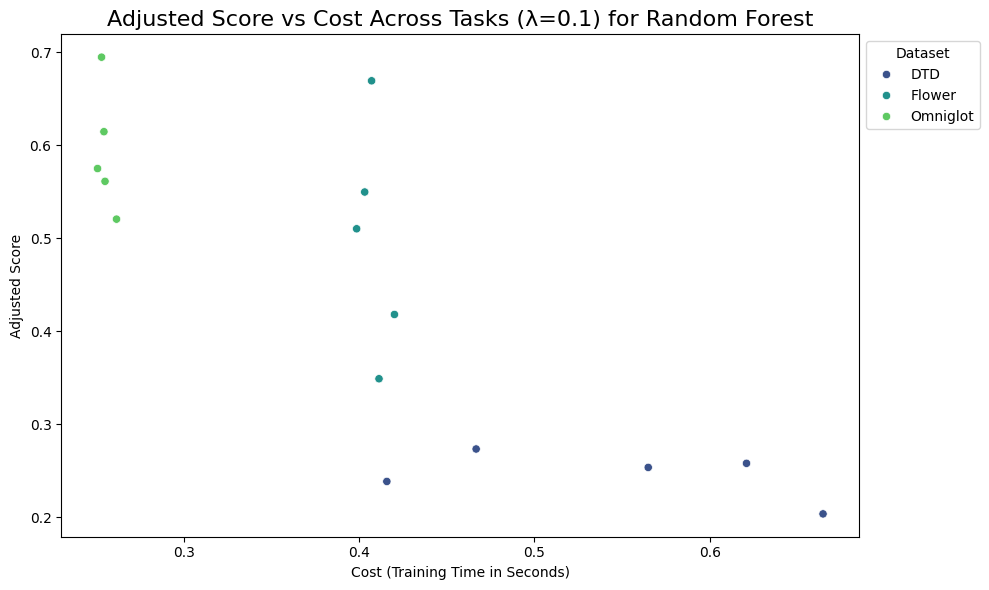

In [38]:
plot_task_metrics(task_metrics, lambda_factor=0.1)

In [40]:
# Stats
# General descriptive stats grouped by dataset
grouped_by_dataset = df_all_rf.groupby('dataset').describe()
# print(grouped_by_dataset)
adjusted_score_summary_rf = grouped_by_dataset['adjusted_score']

# Print the summary for 'adjusted_score'
print(adjusted_score_summary_rf)

          count      mean       std       min       25%       50%       75%  \
dataset                                                                       
DTD         5.0  0.245336  0.026472  0.203534  0.238417  0.253506  0.257899   
Flower      5.0  0.499192  0.123283  0.348864  0.417984  0.510141  0.549681   
Omniglot    5.0  0.593167  0.065959  0.520505  0.561161  0.574921  0.614557   

               max  
dataset             
DTD       0.273323  
Flower    0.669288  
Omniglot  0.694693  


In [58]:
task_error_analysis = df_all_rf.groupby('task')['adjusted_score'].describe()
print(task_error_analysis)

      count      mean       std       min       25%       50%       75%  \
task                                                                      
1       3.0  0.397332  0.134693  0.253506  0.335745  0.417984  0.469245   
2       3.0  0.389308  0.155624  0.257899  0.303382  0.348864  0.455013   
3       3.0  0.494209  0.226491  0.238417  0.406669  0.574921  0.622105   
4       3.0  0.492719  0.211225  0.273323  0.391732  0.510141  0.602417   
5       3.0  0.455924  0.220970  0.203534  0.376608  0.549681  0.582119   

           max  
task            
1     0.520505  
2     0.561161  
3     0.669288  
4     0.694693  
5     0.614557  


### CNN

In [41]:
!pip install scikeras

In [42]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam, SGD
from keras.models import Model

def build_cnn_model(input_shape=(128, 128, 3), activation='relu', dropout_rate=0.5, optimizer='adam', learning_rate=0.001):
    # Input layer
    inputs = Input(shape=input_shape)

    # Convolutional and Pooling Layers
    x = Conv2D(32, (3, 3), activation=activation)(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(64, (3, 3), activation=activation)(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout_rate)(x)

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(128, activation=activation)(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(102, activation='softmax')(x)  # Update number of classes as per your dataset

    # Model
    model = Model(inputs, outputs)

    # Configure optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [43]:
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

cnn_classifier = KerasClassifier(
    model=build_cnn_model,
    activation='relu',           # Default value
    dropout_rate=0.5,            # Default value
    optimizer='adam',            # Default value
    learning_rate=0.001,         # Default value
    epochs=10,
    batch_size=32,
    verbose=0
)

In [44]:
# Assuming you already have parsed the dataset into NumPy arrays
X_train, Y_train = images, labels


# Subsample for faster tuning (optional)
X_subsampled, Y_subsampled = X_train[:1000], Y_train[:1000]  # Adjust sample size as needed
print(f"Subsampled data shape: {X_subsampled.shape}, {Y_subsampled.shape}")

Subsampled data shape: (1000, 49152), (1000,)


In [45]:
# Reshape the data to the expected shape for CNNs
X_train_cnn = X_train.reshape(-1, 128, 128, 3)
X_subsampled_cnn = X_subsampled.reshape(-1, 128, 128, 3)

print(f"Reshaped data shape: {X_train_cnn.shape}, {X_subsampled_cnn.shape}")

Reshaped data shape: (5640, 128, 128, 3), (1000, 128, 128, 3)


In [46]:
# Normalize and reshape for CNN
X_subsampled_cnn = X_train[:100] / 255.0  # Subsample and normalize
Y_subsampled_cnn = Y_train[:100]

# Ensure the shape is (batch_size, 128, 128, 3)
X_subsampled_cnn = X_subsampled_cnn.reshape(-1, 128, 128, 3)

print(f"Reshaped data shape: {X_subsampled_cnn.shape}, {Y_subsampled_cnn.shape}")

Reshaped data shape: (100, 128, 128, 3), (100,)


In [47]:
param_grid = {
    'activation': ['relu', 'tanh'],
    'dropout_rate': [0.3],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.001]
}

grid_search = GridSearchCV(
    estimator=cnn_classifier,
    param_grid=param_grid,
    scoring='accuracy',
    cv=2,
    verbose=2
)


In [48]:
grid_search.fit(X_subsampled_cnn, Y_subsampled_cnn)

# Output the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END activation=relu, dropout_rate=0.3, learning_rate=0.001, optimizer=adam; total time=  30.7s
[CV] END activation=relu, dropout_rate=0.3, learning_rate=0.001, optimizer=adam; total time=  12.6s


[CV] END activation=relu, dropout_rate=0.3, learning_rate=0.001, optimizer=sgd; total time=   8.1s
[CV] END activation=relu, dropout_rate=0.3, learning_rate=0.001, optimizer=sgd; total time=  13.2s
[CV] END activation=tanh, dropout_rate=0.3, learning_rate=0.001, optimizer=adam; total time=  13.2s
[CV] END activation=tanh, dropout_rate=0.3, learning_rate=0.001, optimizer=adam; total time=   9.7s
[CV] END activation=tanh, dropout_rate=0.3, learning_rate=0.001, optimizer=sgd; total time=  13.1s
[CV] END activation=tanh, dropout_rate=0.3, learning_rate=0.001, optimizer=sgd; total time=  12.1s
Best parameters: {'activation': 'relu', 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'adam'}
Best cross-validation accuracy: 1.0


In [49]:
import numpy as np
import time
from sklearn.model_selection import train_test_split
import tensorflow as tf

def create_tasks(X, Y, num_tasks=5, num_classes_per_task=5, num_train_samples=10, num_test_samples=20):
    """
    Create few-shot learning tasks from the dataset.
    Args:
        X (np.ndarray): Dataset features (images).
        Y (np.ndarray): Dataset labels.
        num_tasks (int): Number of tasks to create.
        num_classes_per_task (int): Number of classes per task.
        num_train_samples (int): Number of training samples per class.
        num_test_samples (int): Number of test samples per class.
    Returns:
        list of dict: List of tasks, each containing train and test data.
    """
    tasks = []
    unique_classes = np.unique(Y)
    for _ in range(num_tasks):
        selected_classes = np.random.choice(unique_classes, num_classes_per_task, replace=False)
        X_task, Y_task = [], []
        for c in selected_classes:
            class_indices = np.where(Y == c)[0]
            selected_indices = np.random.choice(class_indices, num_train_samples + num_test_samples, replace=False)
            X_task.append(X[selected_indices])
            Y_task.append([c] * len(selected_indices))

        X_task = np.vstack(X_task)
        Y_task = np.hstack(Y_task)

        # Split into train and test
        X_train, X_test, Y_train, Y_test = train_test_split(
            X_task, Y_task, train_size=num_train_samples * num_classes_per_task
        )

        tasks.append({
            "X_train": X_train,
            "Y_train": Y_train,
            "X_test": X_test,
            "Y_test": Y_test
        })
    return tasks

def evaluate_with_chollet(model, X, Y, num_tasks=5, num_classes=5, num_train_samples=10, num_test_samples=20, lambda_factor=0.1):
    """
    Evaluate the model using Chollet's measure of intelligence, including cost.
    Args:
        model: Pre-trained model to fine-tune and evaluate.
        X (np.ndarray): Dataset features.
        Y (np.ndarray): Dataset labels.
        num_tasks (int): Number of tasks to evaluate.
        num_classes (int): Number of classes per task.
        num_train_samples (int): Training samples per class for each task.
        num_test_samples (int): Test samples per class for each task.
        lambda_factor (float): Weight for penalizing cost (time).
    Returns:
        float: Chollet's Intelligence Score.
        list of dict: Task metrics containing utility (accuracy) and cost (training time) for each task.
    """
    tasks = create_tasks(X, Y, num_tasks, num_classes, num_train_samples, num_test_samples)
    task_metrics = []

    for i, task in enumerate(tasks):
        print(f"Evaluating task {i + 1}/{num_tasks}...")

        # Fine-tune the model on task-specific training data
        task_model = tf.keras.models.clone_model(model)
        task_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

        # Track training time
        start_time = time.time()
        task_model.fit(task["X_train"], task["Y_train"], epochs=3, verbose=0)  # Fine-tuning
        training_time = time.time() - start_time

        # Evaluate on the test set
        _, accuracy = task_model.evaluate(task["X_test"], task["Y_test"], verbose=0)

        # Store task metrics
        task_metrics.append({"utility": accuracy, "cost": training_time})
        print(f"Task {i + 1} accuracy: {accuracy:.2f}, Training Time: {training_time:.2f}s")

    # Compute Chollet's Intelligence Score
    chollet_score = np.mean([tm["utility"] - lambda_factor * tm["cost"] for tm in task_metrics])
    print(f"Chollet's Intelligence Score: {chollet_score:.2f}")

    return chollet_score, task_metrics

In [50]:
# Example: Run Chollet's evaluation on the CNN
num_tasks = 5
num_classes_per_task = 5
num_train_samples = 10
num_test_samples = 20

chollet_score, task_metrics = evaluate_with_chollet(
    model=grid_search.best_estimator_.model_,
    X=X_train_cnn,
    Y=Y_train,
    num_tasks=num_tasks,
    num_classes=num_classes_per_task,
    num_train_samples=num_train_samples,
    num_test_samples=num_test_samples
)

Evaluating task 1/5...
Task 1 accuracy: 0.19, Training Time: 8.48s
Evaluating task 2/5...
Task 2 accuracy: 0.24, Training Time: 22.80s
Evaluating task 3/5...
Task 3 accuracy: 0.29, Training Time: 18.52s
Evaluating task 4/5...
Task 4 accuracy: 0.19, Training Time: 12.30s
Evaluating task 5/5...
Task 5 accuracy: 0.17, Training Time: 7.73s
Chollet's Intelligence Score: -1.18


In [51]:
# Compile metrices for all datasets

# Omniglot CNN
#     utility      cost  adjusted_score  task
# 0  0.520000  6.909874       -0.170987     1
# 1  0.893333  0.211036        0.872230     2
# 2  0.640000  0.206441        0.619356     3
# 3  0.840000  0.207505        0.819249     4
# 4  0.786667  0.206056        0.766061     5

# Flower CNN
#    utility      cost  adjusted_score  task
# 0     0.32  7.371599       -0.417160     1
# 1     0.36  6.177526       -0.257753     2
# 2     0.17  5.897028       -0.419703     3
# 3     0.34  6.113211       -0.271321     4
# 4     0.18  5.991916       -0.419192     5

# Store dataframe of Omniglot RF metrices
omni_cnn_data = {
    'utility': [0.520000, 0.893333, 0.640000, 0.840000, 0.786667],
    'cost': [6.909874, 0.211036, 0.206441, 0.207505, 0.206056],
    'adjusted_score': [-0.170987, 0.872230, 0.619356, 0.819249, 0.766061],
    'task': [1, 2, 3, 4, 5]
}

df_omni_cnn = pd.DataFrame(omni_cnn_data)
df_omni_cnn['dataset'] = 'Omniglot'

# Dataframe of Flower RF metrices
flower_cnn_data = {
    'utility': [0.32, 0.36, 0.17, 0.34, 0.18],
    'cost': [7.371599, 6.177526, 5.897028, 6.113211, 5.991916],
    'adjusted_score': [-0.417160, -0.257753, -0.419703, -0.271321, -0.419192],
    'task': [1, 2, 3, 4, 5]
}

df_flower_cnn = pd.DataFrame(flower_cnn_data)
df_flower_cnn['dataset'] = 'Flower'

# Combine
df_combined_cnn = pd.concat([df_flower_cnn, df_omni_cnn], ignore_index=True)

data = pd.DataFrame(task_metrics)
data['adjusted_score'] = data['utility'] - 0.1 * data['cost']
data['task'] = range(1, len(task_metrics) + 1)  # Add task numbers
data['dataset'] = 'DTD'
df_all_cnn = pd.concat([data, df_combined_cnn], ignore_index=True)
print(df_all_cnn)

     utility       cost  adjusted_score  task   dataset
0   0.190000   8.481642       -0.658164     1       DTD
1   0.240000  22.797614       -2.039761     2       DTD
2   0.290000  18.520840       -1.562084     3       DTD
3   0.190000  12.300716       -1.040072     4       DTD
4   0.170000   7.726256       -0.602626     5       DTD
5   0.320000   7.371599       -0.417160     1    Flower
6   0.360000   6.177526       -0.257753     2    Flower
7   0.170000   5.897028       -0.419703     3    Flower
8   0.340000   6.113211       -0.271321     4    Flower
9   0.180000   5.991916       -0.419192     5    Flower
10  0.520000   6.909874       -0.170987     1  Omniglot
11  0.893333   0.211036        0.872230     2  Omniglot
12  0.640000   0.206441        0.619356     3  Omniglot
13  0.840000   0.207505        0.819249     4  Omniglot
14  0.786667   0.206056        0.766061     5  Omniglot


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_task_metrics(task_metrics, lambda_factor=0.1):
    """
    Visualize the relationship between utility, cost, and adjusted score across tasks.

    Args:
        task_metrics (list): List of dictionaries with "utility" and "cost" for each task.
        lambda_factor (float): Lambda factor used in Chollet's measure.
    """

   # Plot adjusted score vs cost
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x='cost',
        y='adjusted_score',
        hue='dataset',
        data=df_all_cnn,
        palette='viridis',
        sizes=(100, 500),
        legend='full'
    )
    plt.title(f"Adjusted Score vs Cost Across Tasks (λ={lambda_factor}) for Convolutional Neural Network", fontsize=16)
    plt.xlabel("Cost (Training Time in Seconds)")
    plt.ylabel("Adjusted Score")
    plt.legend(title="Dataset", loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

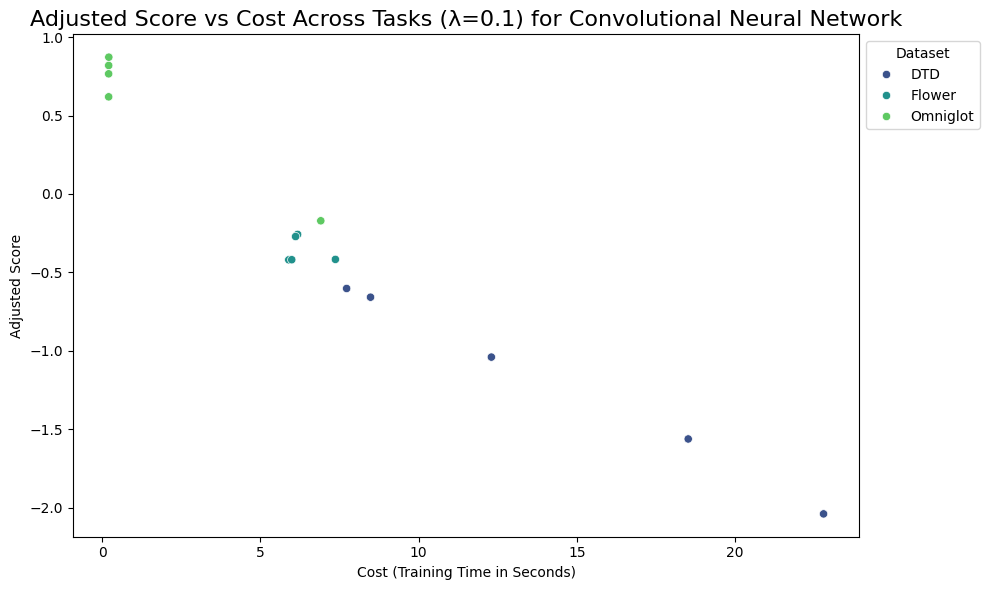

In [53]:
plot_task_metrics(task_metrics, lambda_factor=0.1)

In [54]:
# Stats
# General descriptive stats grouped by dataset
grouped_by_dataset = df_all_cnn.groupby('dataset').describe()
# print(grouped_by_dataset)
adjusted_score_summary_cnn = grouped_by_dataset['adjusted_score']

# Print the summary for 'adjusted_score'
print(adjusted_score_summary_cnn)

          count      mean       std       min       25%       50%       75%  \
dataset                                                                       
DTD         5.0 -1.180541  0.614498 -2.039761 -1.562084 -1.040072 -0.658164   
Flower      5.0 -0.357026  0.084572 -0.419703 -0.419192 -0.417160 -0.271321   
Omniglot    5.0  0.581182  0.430924 -0.170987  0.619356  0.766061  0.819249   

               max  
dataset             
DTD      -0.602626  
Flower   -0.257753  
Omniglot  0.872230  


In [57]:
task_error_analysis = df_all_cnn.groupby('task')['adjusted_score'].describe()
print(task_error_analysis)

      count      mean       std       min       25%       50%       75%  \
task                                                                      
1       3.0 -0.415437  0.243593 -0.658164 -0.537662 -0.417160 -0.294073   
2       3.0 -0.475095  1.468112 -2.039761 -1.148757 -0.257753  0.307238   
3       3.0 -0.454144  1.091128 -1.562084 -0.990894 -0.419703  0.099827   
4       3.0 -0.164048  0.934291 -1.040072 -0.655696 -0.271321  0.273964   
5       3.0 -0.085252  0.742942 -0.602626 -0.510909 -0.419192  0.173435   

           max  
task            
1    -0.170987  
2     0.872230  
3     0.619356  
4     0.819249  
5     0.766061  
